# Topo MWTA Cifar Color

## Intro
* **Date**: 1/17/2021
* **What**: Literally just standard topo mwta, but I'm training it on Cifar10 colored 10x10 sections.  I simply yearn to see what the topology of the colored prototypes looks like.
* **Why**: Because I'm a child and I want to see pretty pictures.
* **Hopes**: This is incredibly qualitative.  I literally want to see the pretty pictures.  And hey, mother fucker?  You do to.  Trust me.  Whose been staring at topologically organized feature-prototype spaces, you or me?  Yeah, that's right.  Mama knows best.
* **Limitations**: Oh lord only knows.  Given how experiments have been going, a demi-gorgon might literally erupt from my screen at any second and eat my face of, thus ruining the experiment.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import cifar10
from tqdm import tqdm

(tr_x, _), (te_x, _) = cifar10.load_data()

tr_x = np.moveaxis(tr_x, 1, 3)
te_x = np.moveaxis(te_x, 1, 3)

In [2]:
s_len = 10
slh = s_len // 2
sl2 = s_len * s_len

data = tr_x[:, 16 - slh: 16 + slh, 16 - slh: 16 + slh]
flat_data = data.reshape(-1, sl2 * 3) / 255.0
fd_len = flat_data.shape[0]

te_data = te_x[:, 16 - slh: 16 + slh, 16 - slh: 16 + slh]
te_flat_data = te_data.reshape(-1, sl2 * 3) / 255.0

In [3]:
gp_data = cp.asarray(flat_data)

In [ ]:
def draw_color_weights(w, Kx, Ky, fig, s_len):
    tapestry = np.zeros((s_len * Kx, s_len * Ky, 3))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len, 3)
            w_i += 1
            
    plt.clf()        
    im = plt.imshow(tapestry / np.maximum(1e-10, np.max(tapestry)), vmin=0)
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


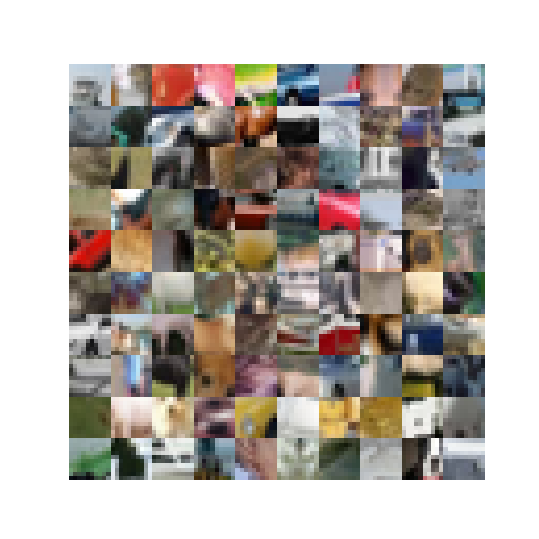

In [16]:
fig = plt.figure(figsize=(6, 6))
offset = 100
draw_color_weights(gp_data[offset:offset + 100].reshape(100, -1).get(), 10, 10, fig, 10)

In [8]:
def gen_lat_ex(Kx, Ky, ex, coeff):

    lat_ex = []

    for y in range(Ky):
        for x in range(Kx):
            curr_ex = np.zeros((Ky, Kx))
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if y - ex < 0:
                curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            if y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if x - ex < 0:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
            if x + ex + 1 > Kx:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x - ex < 0:
                curr_ex[y - ex:, x - ex:] = 1

            if x + ex + 1 > Kx and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x + ex + 1 > Kx:
                curr_ex[y - ex:, :x + ex + 1 - Kx] = 1


            if x - ex < 0 and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, x - ex:] = 1

            lat_ex.append(curr_ex.reshape(-1))

    lat_ex = cp.array(lat_ex)
    np.fill_diagonal(lat_ex, 0)

    lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * coeff
    np.fill_diagonal(lat_ex, 1)
    
    return lat_ex

# Analysis Dialog

For some unholy reason, the axes were switched on the cifar10 data, so I just spent too much time (~3 min) getting that sorted out.  Aight bois, here we go.

<IPython.core.display.Javascript object>


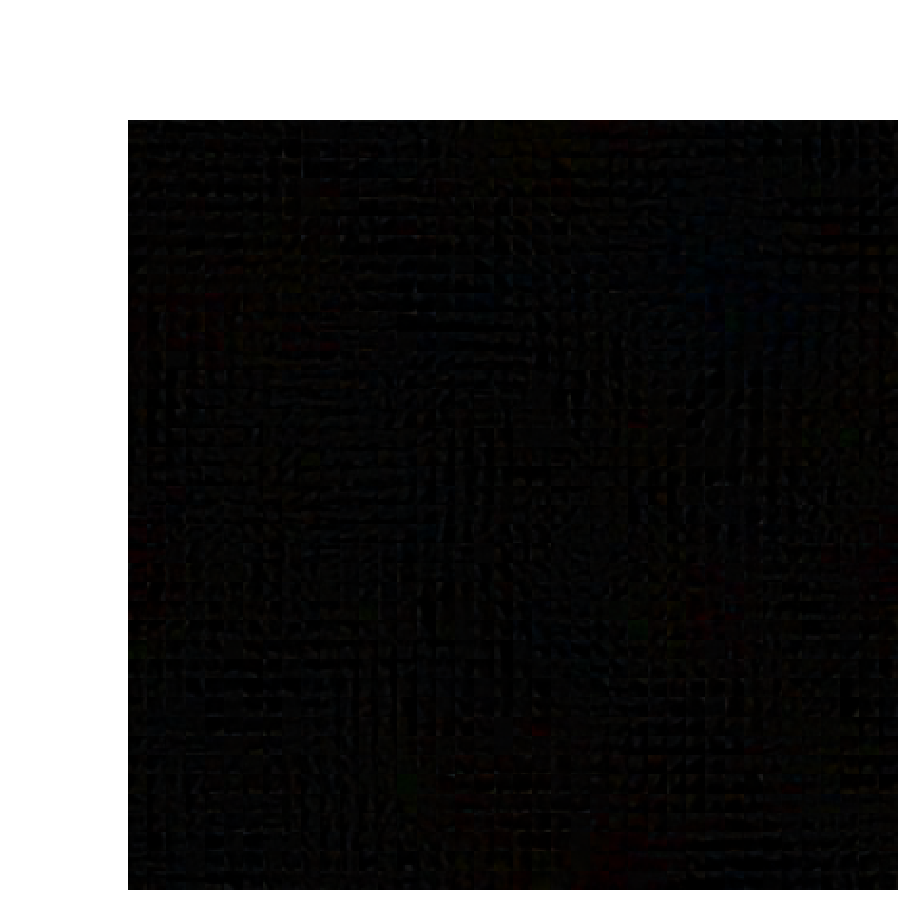

 45%|████▌     | 4522/10000 [00:03<00:03, 1472.65it/s]


KeyboardInterrupt: 

In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000

Kx = 40
Ky = 40
N = Kx * Ky
m_len = sl2 * 3
tr_len = 60_000
ex = 2
coeff = 0.5

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.05

lat_ex = gen_lat_ex(Kx, Ky, ex, coeff)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_color_weights(w.get(), Kx, Ky, fig, s_len)

Yug.  I'm not seeing the pretty pictures I wanted to see.  I'm going to increase the number of winners to 30.

<IPython.core.display.Javascript object>


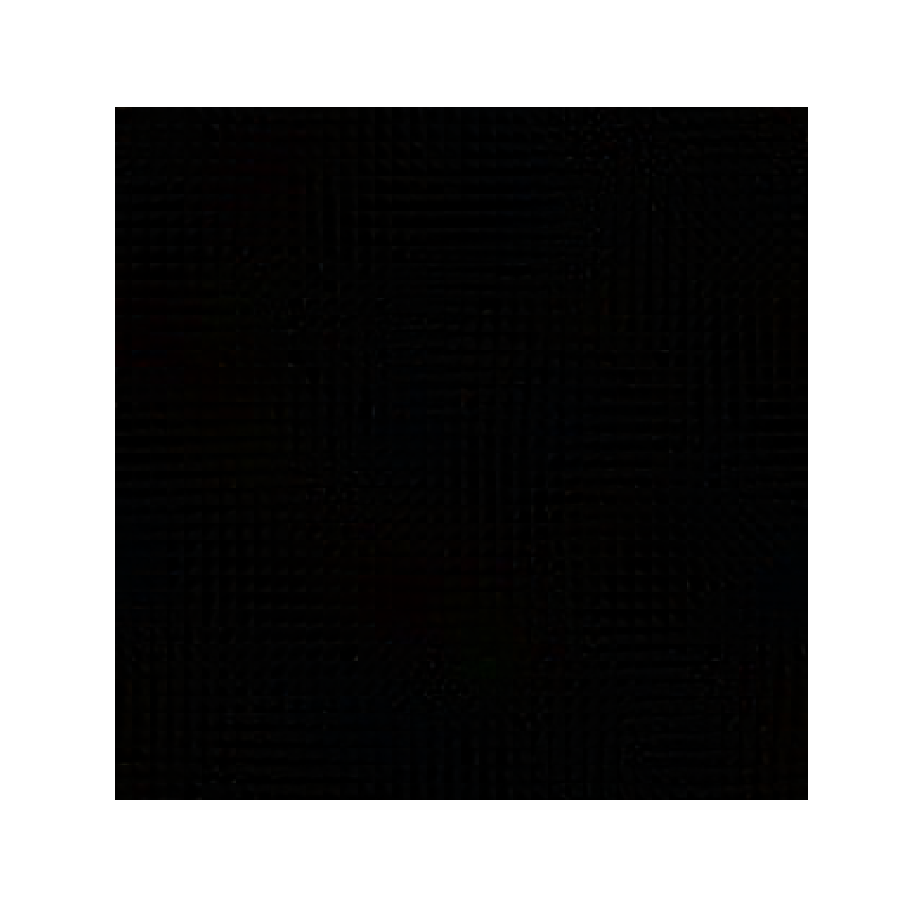

100%|██████████| 10000/10000 [00:06<00:00, 1565.75it/s]


In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000

Kx = 40
Ky = 40
N = Kx * Ky
m_len = sl2 * 3
tr_len = 60_000
ex = 2
coeff = 0.5

prec = 1e-10

n_w = 30 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.005

lat_ex = gen_lat_ex(Kx, Ky, ex, coeff)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_color_weights(w.get(), Kx, Ky, fig, s_len)

I think it's reasonable for me to want more than that.  I'm going to mess with `draw_color_weights`.

<IPython.core.display.Javascript object>


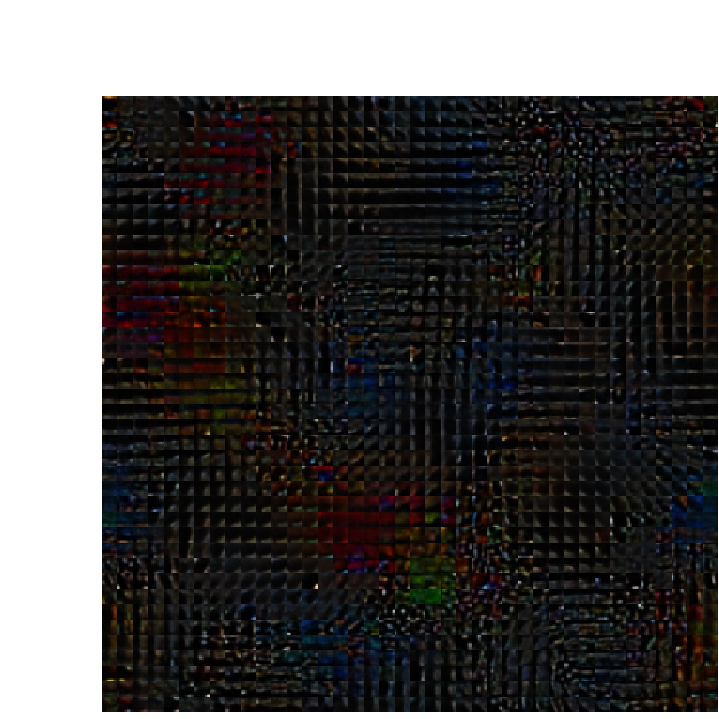

 58%|█████▊    | 5765/10000 [00:03<00:02, 1530.66it/s]


KeyboardInterrupt: 

In [19]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_color_weights(w.get(), Kx, Ky, fig, s_len)

Yeah.  That's what I'm talking about, baby.  Ok, now that I've got that one looking pretty, I'm going to try 10 winners again, see how that goes.  Also, more neurons because why the fuck not?

<IPython.core.display.Javascript object>


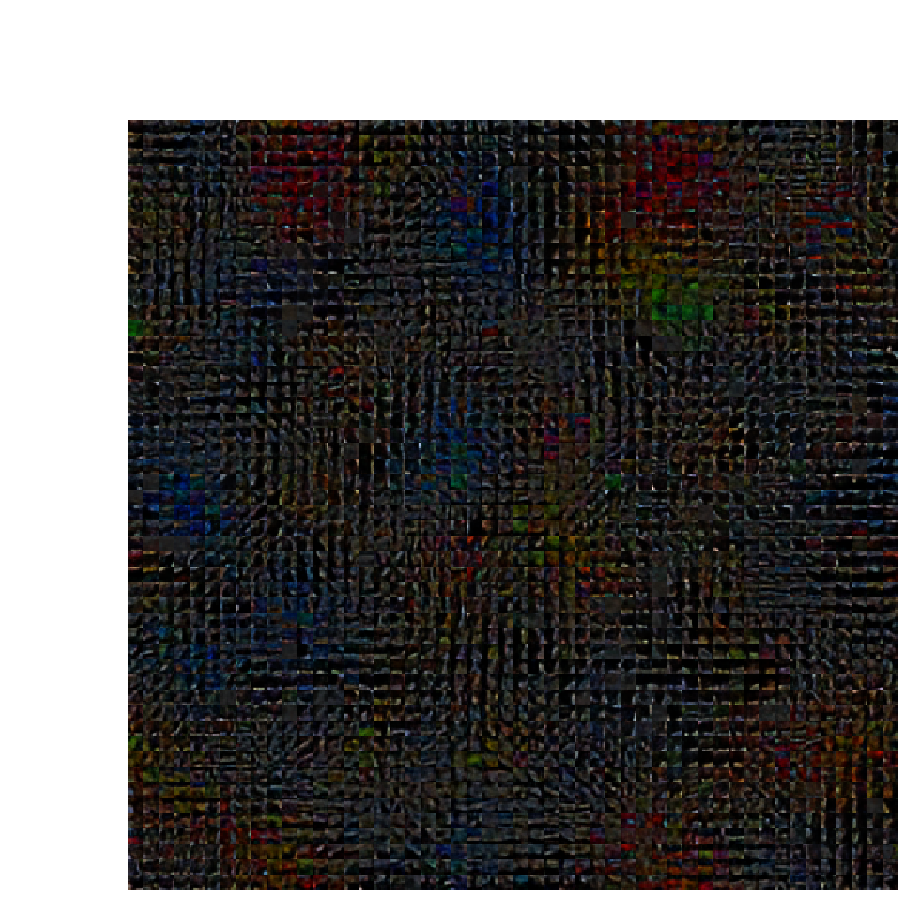

  9%|▉         | 943/10000 [00:00<00:07, 1234.92it/s]


KeyboardInterrupt: 

In [21]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000

Kx = 50
Ky = 50
N = Kx * Ky
m_len = sl2 * 3
tr_len = 60_000
ex = 2
coeff = 0.5

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.05

lat_ex = gen_lat_ex(Kx, Ky, ex, coeff)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_color_weights(w.get(), Kx, Ky, fig, s_len)

You know what?  I might honestly like the feature space with 30 winners better.  I'm going to do a couple reconstructions though, see what we're looking at.

<IPython.core.display.Javascript object>


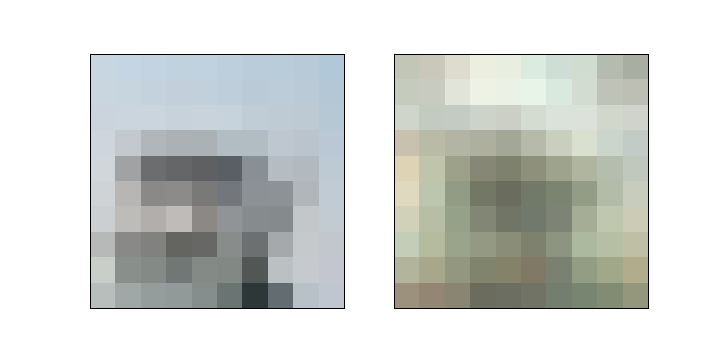

In [30]:
img_i = 100

v = gp_data[img_i].reshape(-1, 1)
p = w @ v
c = p + (lat_ex @ p)
winners = cp.argsort(c, axis=0)[-n_w:]
mask = cp.zeros((N, 1))
mask[winners] = 1
o = mask * p
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(v.reshape(s_len, s_len, 3).get())

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3).get())

plt.show()

Fam, that's not fantastic.  I'll tell you that much.  I'm going to do 30 winners again, and see what we can get.  Also these feature spaces are looking so good I might send them right on over to Olshausen.

<IPython.core.display.Javascript object>


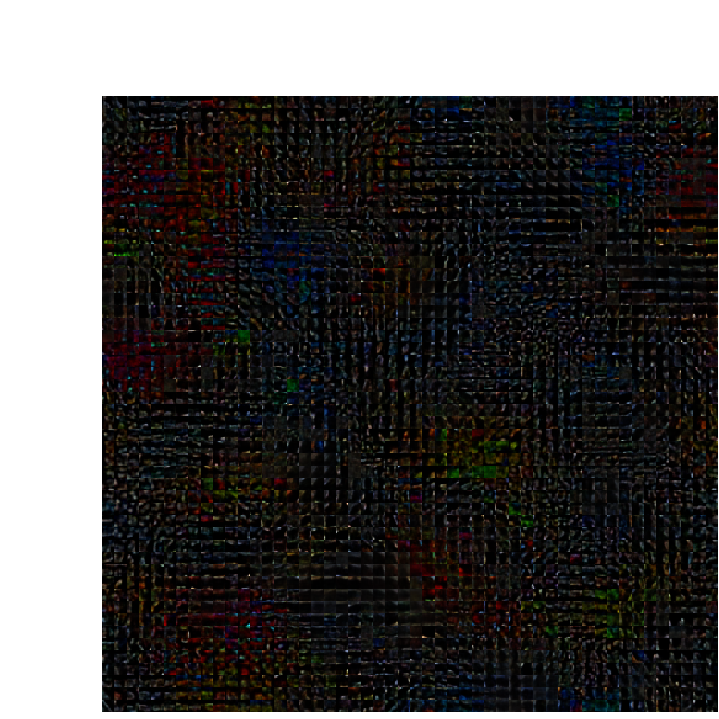

 22%|██▏       | 2160/10000 [00:01<00:05, 1311.42it/s]


KeyboardInterrupt: 

In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 20
T_s = 10_000

Kx = 50
Ky = 50
N = Kx * Ky
m_len = sl2 * 3
tr_len = 50_000
ex = 2
coeff = 0.5

prec = 1e-10

n_w = 30 #Number of winners

# Feedforward
w = cp.random.uniform(.21, .22, (N, m_len))
xi = 0.05

lat_ex = gen_lat_ex(Kx, Ky, ex, coeff)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_color_weights(w.get(), Kx, Ky, fig, s_len)

<IPython.core.display.Javascript object>


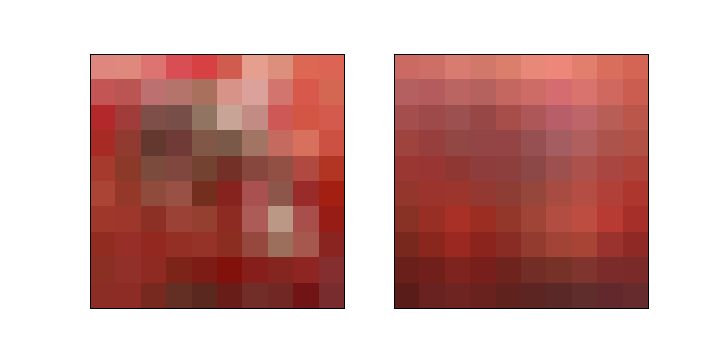

In [43]:
img_i = 5

v = gp_data[img_i].reshape(-1, 1)
p = w @ v
c = p + (lat_ex @ p)
winners = cp.argsort(c, axis=0)[-n_w:]
mask = cp.zeros((N, 1))
mask[winners] = 1
o = mask * p
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(v.reshape(s_len, s_len, 3).get())

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3).get())

plt.show()

You know what?  I'm going to train on 50 winners.

<IPython.core.display.Javascript object>


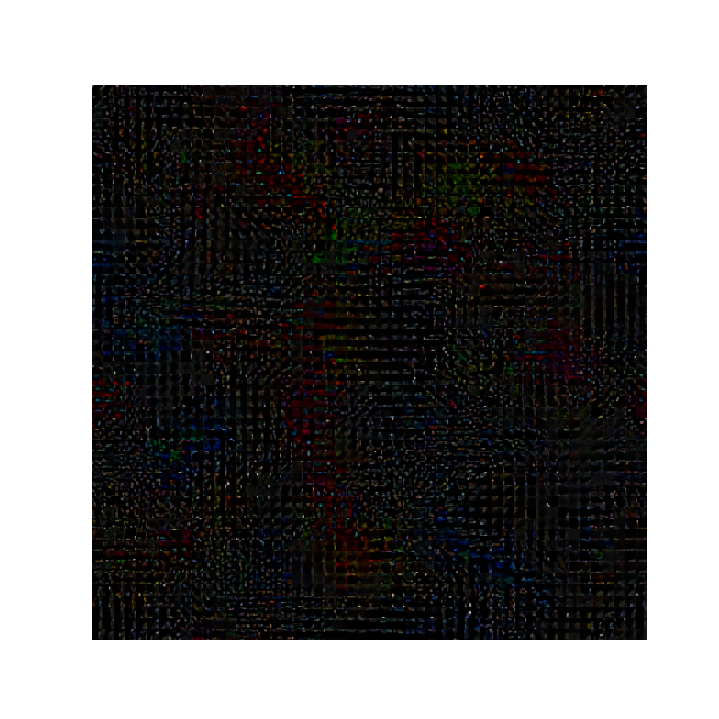

100%|██████████| 10000/10000 [00:07<00:00, 1306.63it/s]


In [44]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 20
T_s = 10_000

Kx = 50
Ky = 50
N = Kx * Ky
m_len = sl2 * 3
tr_len = 50_000
ex = 2
coeff = 0.5

prec = 1e-10

n_w = 50 #Number of winners

# Feedforward
w = cp.random.uniform(.21, .22, (N, m_len))
xi = 0.05

lat_ex = gen_lat_ex(Kx, Ky, ex, coeff)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_color_weights(w.get(), Kx, Ky, fig, s_len)

Hmm.  Ok, let's see what we can see with 40 winners.

<IPython.core.display.Javascript object>


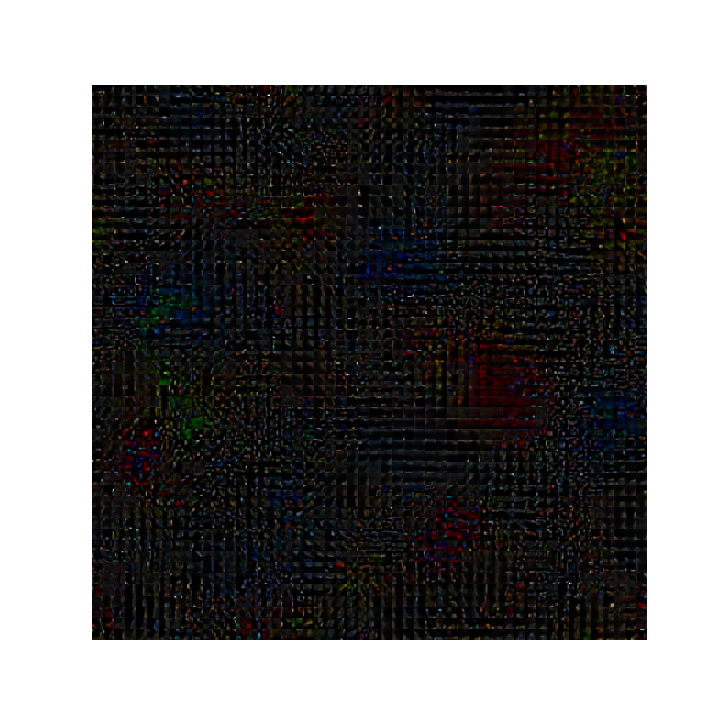

100%|██████████| 10000/10000 [00:07<00:00, 1291.56it/s]


In [45]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 10
T_s = 10_000

Kx = 50
Ky = 50
N = Kx * Ky
m_len = sl2 * 3
tr_len = 50_000
ex = 2
coeff = 0.5

prec = 1e-10

n_w = 40 #Number of winners

# Feedforward
w = cp.random.uniform(.21, .22, (N, m_len))
xi = 0.05

lat_ex = gen_lat_ex(Kx, Ky, ex, coeff)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_color_weights(w.get(), Kx, Ky, fig, s_len)

<IPython.core.display.Javascript object>


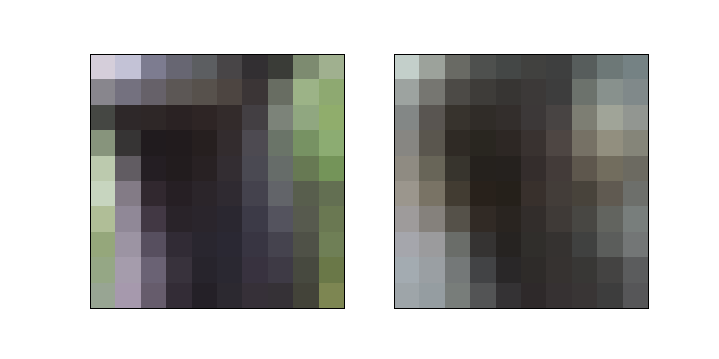

In [54]:
img_i = 55

v = gp_data[img_i].reshape(-1, 1)
p = w @ v
c = p + (lat_ex @ p)
winners = cp.argsort(c, axis=0)[-n_w:]
mask = cp.zeros((N, 1))
mask[winners] = 1
o = mask * p
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(v.reshape(s_len, s_len, 3).get())

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3).get())

plt.show()

The reconstructions still aren't that great.  I think maybe training this on HSV might be better.  It looks like it's getting a good portion of the structure correct, just not the colors.

Ok, as a final measure, I'm going to train this on 10,000 neurons.  My fav.

<IPython.core.display.Javascript object>


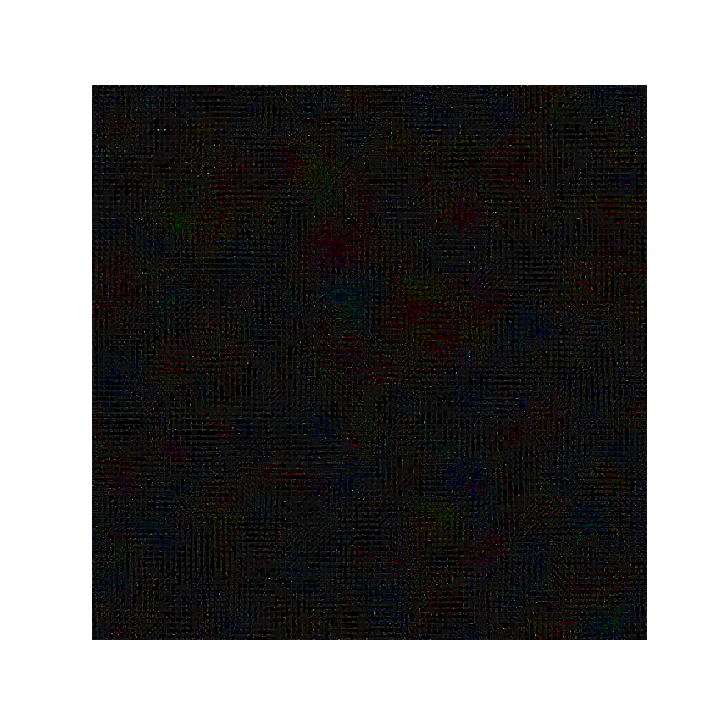

100%|██████████| 10000/10000 [00:24<00:00, 411.71it/s]


In [55]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 10
T_s = 10_000

Kx = 100
Ky = 100
N = Kx * Ky
m_len = sl2 * 3
tr_len = 50_000
ex = 2
coeff = 0.5

prec = 1e-10

n_w = 40 #Number of winners

# Feedforward
w = cp.random.uniform(.21, .22, (N, m_len))
xi = 0.1

lat_ex = gen_lat_ex(Kx, Ky, ex, coeff)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_color_weights(w.get(), Kx, Ky, fig, s_len)

<IPython.core.display.Javascript object>


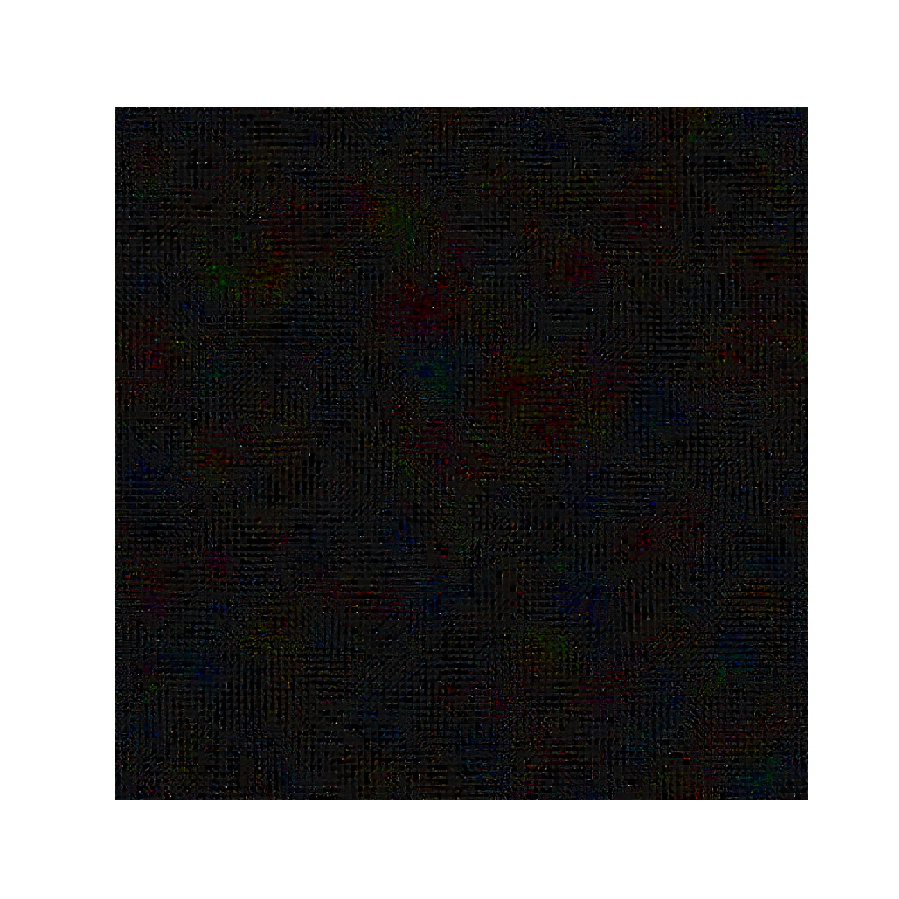

In [56]:
fig = plt.figure(figsize=(10, 10))
draw_color_weights(w.get(), Kx, Ky, fig, s_len)

RECONSTRUCTIONS!!

<IPython.core.display.Javascript object>


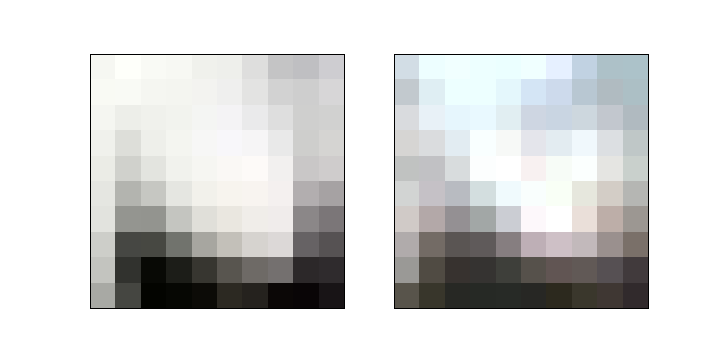

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [79]:
img_i = 13

v = cp.asarray(te_flat_data[img_i].reshape(-1, 1))
p = w @ v
c = p + (lat_ex @ p)
winners = cp.argsort(c, axis=0)[-n_w:]
mask = cp.zeros((N, 1))
mask[winners] = 1
o = mask * p
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(v.reshape(s_len, s_len, 3).get())

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3).get())

plt.show()

Ok, that's pretty good. Unsurprisingly, the reconstructions get better as you add neurons.  :)

## Conclusions

Well dope.  They look cool.  In fact, the feature spaces look so good I might just send them over to Olshausen, see what he thinks.

Yeah that's what I'm going to do.

## Next steps

Email pretty pictures to Olshausen.  Also I need to implement the new sparsity model.  Threshold sparsity, baby.  Basically, we get sparsity, but there isn't a hard guarentee on the number of neurons that win.